In [11]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segyio
import scipy.signal
import scipy.interpolate
from scipy.interpolate import interp1d
import pylops
import seaborn as sns
import cmocean as cm
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [12]:
print('Numpy', np.__version__)
print('Scipy', scipy.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', matplotlib.__version__)
print('Pylops', pylops.__version__)

Numpy 1.24.3
Scipy 1.10.1
Pandas 1.5.3
Matplotlib 3.7.2
Pylops 2.1.0


In [13]:
#Loading seismic using Segyio lib

# string containing the path location of the seismic data at disk
segy_file_path = '..\Seismic\TIME_R0321_COMPLEX_ALBACORA_PSDM_4ms.segy'

#loading stack using Segyio lib
stack = segyio.open(segy_file_path,iline=segyio.TraceField.INLINE_3D, 
                xline=segyio.tracefield.TraceField.CROSSLINE_3D) 
#Allocating IL, XL, Time axis in variables
il, xl, t = stack.ilines, stack.xlines, stack.samples
#Measuring Sample rate from data samples
dt = t[1] - t[0]
#Creating seismic cube format using segyio cube method
data_cube = segyio.cube(stack)
#Qc of the axis shapes
nil, nxl, nt = data_cube.shape

# Inlines information
il_start, il_end = il[0], il[-1]
    
# Crosslines information
xl_start, xl_end = xl[0], xl[-1]

In [14]:
print('Seismic amplitude data information \n --------------------------------------------------')
print('Shape of data [n_il, n_xl, n_samples]: ', nil, nxl, nt)
print('Inline start:', il_start, '    ', 'Inline end:', il_end)
print('Crossline start:', xl_start, '    ', 'Crossline end:', xl_end)
print('Sample rate [ms]:', dt)
print('Number of samples by trace:', stack.tracecount)      
print('Two-way-time array:', t)

Seismic amplitude data information 
 --------------------------------------------------
Shape of data [n_il, n_xl, n_samples]:  1798 1995 1695
Inline start: 1366      Inline end: 3163
Crossline start: 1713      Crossline end: 3707
Sample rate [ms]: 3.99
Number of samples by trace: 3587010
Two-way-time array: [0.00000e+00 3.99000e+00 7.98000e+00 ... 6.75108e+03 6.75507e+03
 6.75906e+03]


In [15]:
filename = "../Low_Frequency_Model_Data/LF_Model_Angle45.sgy"

In [16]:
segy_file_path = filename

#loading stack using Segyio lib
m0 = segyio.open(segy_file_path,iline=segyio.TraceField.INLINE_3D, 
                xline=segyio.tracefield.TraceField.CROSSLINE_3D) 
#Allocating IL, XL, Time axis in variables
m0_il, m0_xl, m0_t = m0.ilines, m0.xlines, m0.samples
#Measuring Sample rate from data samples
m0_dt = m0_t[1] - m0_t[0]
#Creating seismic cube format using segyio cube method
m0_cube = segyio.cube(m0)
#Qc of the axis shapes
m0_nil, m0_nxl, m0_nt = m0_cube.shape

# Inlines information
m0_il_start, m0_il_end = m0_il[0], m0_il[-1]
    
# Crosslines information
m0_xl_start, m0_xl_end = m0_xl[0], m0_xl[-1]

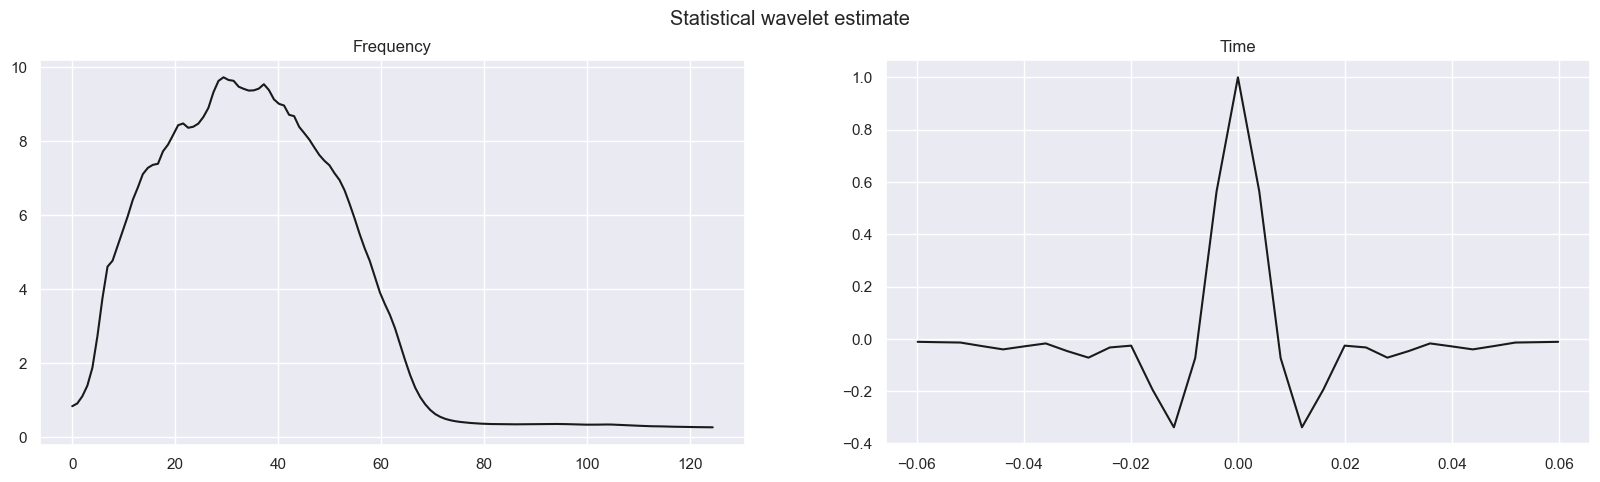

In [18]:
#Another wavelet estimation method

nt_wav = 16 # lenght of wavelet in samples
nfft = 2**8 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(data_cube[..., 425:1025], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav,wav_est, 'k')
axs[1].set_title('Time');

In [42]:
# Inverting at Volume

ip_vol = np.full_like(data_cube, np.nan)

for i in range(data_cube.shape[0]):
    # Seismic amplitude section
    amp = data_cube[i, :, 425:1025].T
    
    # Log of the low frequency model of impedance
    mback = np.log(m0_cube[i, :, 425:1025].T)
    # Wavelet operator
    nz, nx = amp.shape
    PPop = pylops.avo.poststack.PoststackLinearModelling(wav_est/2,
                                                        nt0=nz,
                                                        spatdims=nx,
                                                        explicit=True)

    # Trace-by-trace
    minv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
        Op=PPop,
        y=amp.ravel() / 10,
        Regs=None,
        epsI=4e-1,
        x0=mback.ravel(),
        engine='scipy',
        **dict(maxiter=1000))
    minv_tbt = np.exp(mback + minv_tbt.reshape(nz, nx))
    ip_vol[i,:, 425:1025] = minv_tbt.T
    print(f'Running IL {i+1}/{data_cube.shape[0]}\r', end="")

In [74]:
topo = pd.read_csv("..\Horizons\\MAIO_23_updated\\ABL_140_TOPO_updated.dat",
                 sep='\s+', usecols=(0, 1, 4), names=['X', 'Y', 'Z'])
topo_surface = np.full((nil, nxl), np.nan, dtype=np.float32)
ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 
for idx, inline in enumerate(ils):
    x = topo.loc[topo.X == inline].Y
    y = topo.loc[topo.X == inline].Z
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    topo_surface[idx, :] = interp(xls)
    print(f'Inline {inline}/{ils[-1]}\r', end="")   

base = pd.read_csv("..\Horizons\\IN_XLINES\\BASE_AB_140_SEISWORKS.dat",
                 sep='\s+', usecols=(0, 1, 4), names=['X', 'Y', 'Z'])
base_surface = np.full((nil, nxl), np.nan, dtype=np.float32)
ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 
for idx, inline in enumerate(ils):
    x = base.loc[base.X == inline].Y
    y = base.loc[base.X == inline].Z
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    base_surface[idx, :] = interp(xls)
    print(f'Inline {inline}/{ils[-1]}\r', end="")    


In [75]:
base_surface.shape

(1798, 1995)

In [76]:
# Maps
map_topo = np.full((nil, nxl), np.nan)
map_base = np.full((nil, nxl), np.nan)

for i in range(0, nil):
    for j in range(0, nxl):
        map_topo[i, j] = np.mean(ip_vol[i, j,
                                   int(topo_surface[i, j]//4):int(topo_surface[i, j]//4 + 10)])
        map_base[i, j] = np.mean(ip_vol[i, j,
                                      int(base_surface[i, j]//4 - 10):int(base_surface[i, j]//4)])

In [77]:
import matplotlib.colors as colors

# create a list of hexadecimal color codes
hex_colors = ['#631213', '#A92219', '#E42B19', '#FF2E17', '#FF4F1C', '#FF8427', '#FFB031', 
              '#FFDB3B', '#F1E443', '#B8D544', '#78C647', '#5BBE49', '#3BB851', '#1F8781',
              '#1451AC', '#1F4AA7', '#2148A5', '#30319A']

# create a list of normalized values from 0 to 1
values = np.linspace(0, 1, len(hex_colors))

# create a dictionary with the color values for each segment
colors_dict = {value: color for value, color in zip(values, hex_colors)}

# create a LinearSegmentedColormap using the dictionary of color values
cmap = colors.LinearSegmentedColormap.from_list('my_cmap', list(colors_dict.items()))

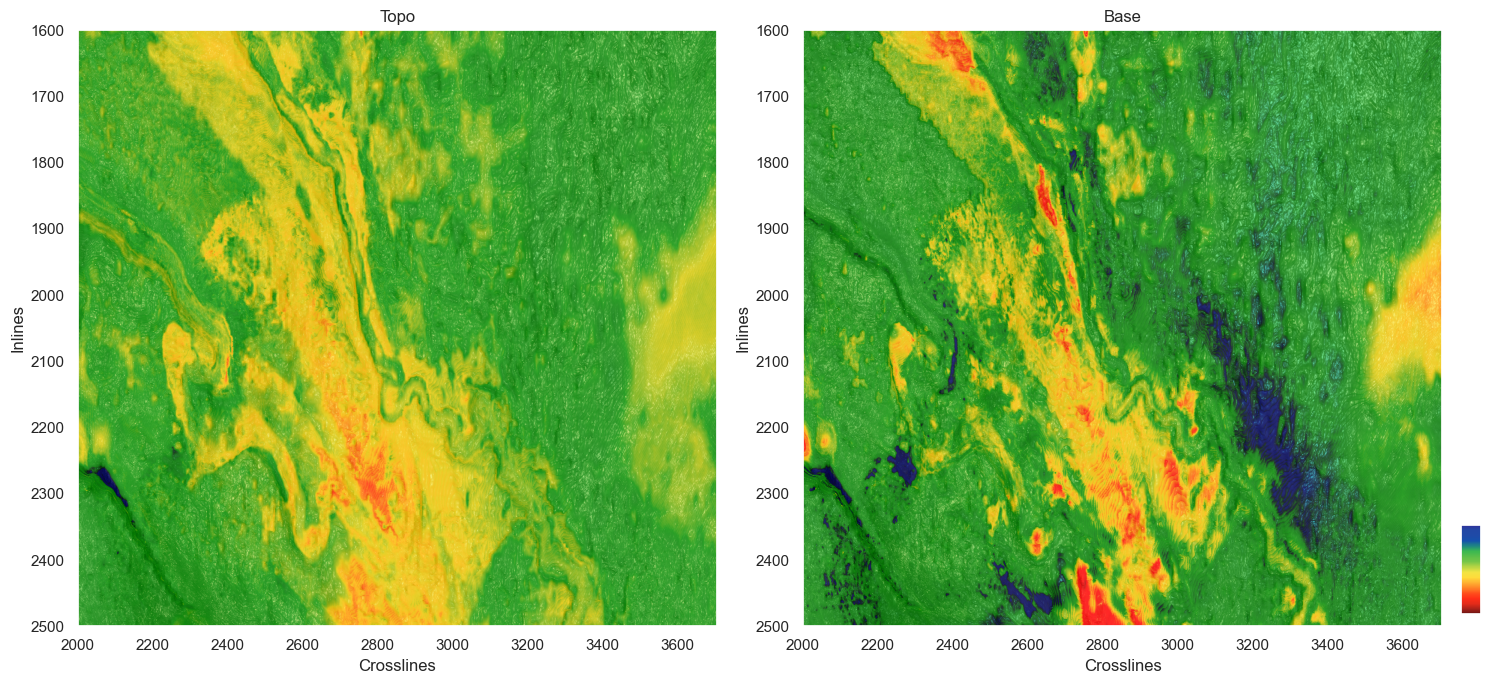

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

im = ax[1].imshow(map_base, cmap=cmap)
im.remove()
axin1 = ax[1].inset_axes([1.03, 0.02, 0.03, 0.15])
axin1.grid(False)
axin1.set(xticks=[],
          yticks=[])
plt.colorbar(im, cax=axin1, ticks=[])

ls = colors.LightSource(azdeg = 90, altdeg = 90)
rgb = ls.shade(map_topo, cmap=cmap, blend_mode='overlay', vmin=4000, vmax=8000,
               vert_exag=1)
ax[0].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start], cmap=cmap)

ls = colors.LightSource(azdeg = 90, altdeg = 45)
rgb = ls.hillshade(topo_surface, vert_exag=1)
c0=ax[0].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start],
                cmap='gray', alpha=0.15)


ls = colors.LightSource(azdeg = 90, altdeg = 90)
rgb = ls.shade(map_base, cmap=cmap, blend_mode='overlay', vmin=5000, vmax=7000,
               vert_exag=1)
ax[1].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start], cmap=cmap)

ls = colors.LightSource(azdeg = 90, altdeg = 45)
rgb = ls.hillshade(base_surface, vert_exag=1)
c0=ax[1].imshow(rgb, aspect='auto', extent=[xl_start, xl_end-3, il_end, il_start],
                cmap='gray', alpha=0.15)

for axs in fig.get_axes():
    axs.grid(False)
    axs.set_xlabel('Crosslines')
    axs.set_ylabel('Inlines')
    '''axs.scatter(5118, 3534, color='k', zorder=20, edgecolor='w')
    axs.scatter(5462, 3100, color='k', zorder=20, edgecolor='w')
    axs.scatter(4722, 3331, color='k', zorder=20, edgecolor='w')
    axs.scatter(4765, 3493, color='k', zorder=20, edgecolor='w')
    axs.scatter(5305, 2996, color='k', zorder=20, edgecolor='w')
    axs.scatter(5370, 3230, color='k', zorder=20, edgecolor='w')
    axs.scatter(5553, 2862, color='k', zorder=20, edgecolor='w')
    axs.scatter(5313, 3157, color='k', zorder=20, edgecolor='w')'''
    #axs.set_xlim(2000, xl_end)
    #axs.set_ylim(2500, 1600)
    
ax[0].set_title('Topo')
ax[1].set_title('Base')

plt.tight_layout()

#plt.savefig('Figures/maps.png', dpi=250, bbox_inches='tight')

In [103]:
flat_volume = np.reshape(ip_vol, (ip_vol.shape[0]*ip_vol.shape[1], -1))

In [104]:
# Saving data: write segy

with segyio.open(filename) as src:
    spec = segyio.spec()
    spec.sorting = src.sorting
    spec.format = src.format
    spec.samples = src.samples
    spec.ilines = src.ilines
    spec.xlines = src.xlines
    print(len(spec.ilines), len(spec.xlines), len(spec.samples))
    
    with segyio.create('../P_Impedance_Volume.sgy', spec) as dst:
        tr = 0
        for il in spec.ilines:
            for xl in spec.xlines:
                dst.header[tr] = {
                    segyio.su.iline  : il,
                    segyio.su.xline  : xl}

                dst.trace[tr] = flat_volume[tr]
                tr += 1
                    
        dst.bin.update(
            tsort=segyio.TraceSortingFormat.INLINE_SORTING
        )

1798 1995 1695
